In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px 
import seaborn as sns
import unidecode, re
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report
from scipy import *
from sklearn.feature_selection import SelectKBest, f_regression
from catboost import CatBoostClassifier
import joblib

ModuleNotFoundError: No module named 'catboost'

In [6]:
df = pd.read_csv("data/train.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 498320 entries, 0 to 498319
Data columns (total 32 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   DT_NOTIFIC  498320 non-null  object 
 1   CS_SEXO     498320 non-null  object 
 2   CO_RG_RESI  425135 non-null  float64
 3   ID_MN_RESI  498276 non-null  object 
 4   CS_ZONA     445482 non-null  float64
 5   NU_IDADE_N  498320 non-null  int64  
 6   CS_ESCOL_N  351419 non-null  float64
 7   CS_RACA     478936 non-null  float64
 8   SG_UF       498276 non-null  object 
 9   CS_GESTANT  498320 non-null  int64  
 10  PUERPERA    199555 non-null  float64
 11  DIABETES    245929 non-null  float64
 12  PNEUMOPATI  205918 non-null  float64
 13  IMUNODEPRE  202774 non-null  float64
 14  RENAL       205586 non-null  float64
 15  OBESIDADE   207458 non-null  float64
 16  OBES_IMC    14525 non-null   float64
 17  CARDIOPATI  262137 non-null  float64
 18  SIND_DOWN   200235 non-null  float64
 19  HE

In [ ]:
df.isnull().sum()

In [7]:
df.groupby('SG_UF').size().reset_index(name='count').sort_values(by='count', ascending=False)

,SG_UF,count
25,SP,144896
18,RJ,54916
10,MG,37441
22,RS,25821
17,PR,25644
15,PE,22922
5,CE,19868
4,BA,17989
8,GO,17240
23,SC,16459


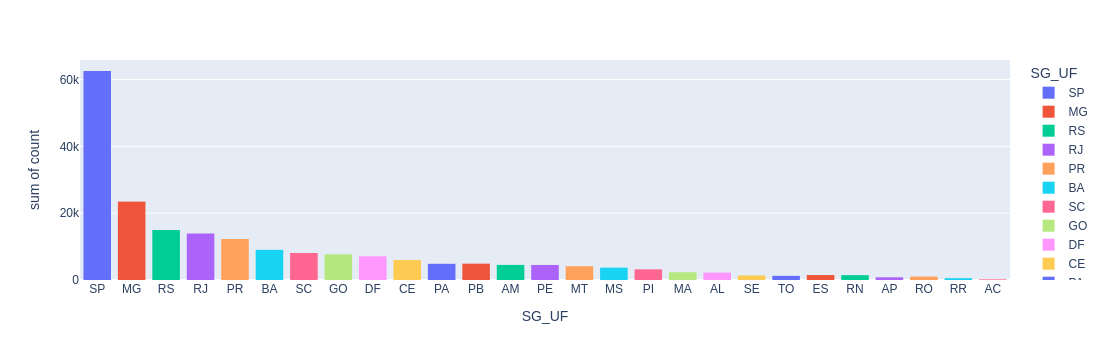

In [8]:
px.histogram(
    df.groupby(['SG_UF','OBESIDADE']).size().reset_index(name='count').sort_values(by='count', ascending=False),
    x='SG_UF',
    y='count',
    color='SG_UF')

In [23]:

x = df.groupby('GARGANTA').size().reset_index(name='count').sort_values(by='count', ascending=False)

px.histogram(
     x,
     x='GARGANTA',
     y='count',
     color='GARGANTA')
x

,GARGANTA,count
1,2.0,272810
0,1.0,88554
2,9.0,12518


In [ ]:
px.histogram(
    df.groupby(['SG_UF','CS_SEXO']).size().reset_index(name='count').sort_values(by='count', ascending=False),
    x='SG_UF',
    y='count',
    color='SG_UF')